In [3]:
!pip install imbalanced-learn

import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from google.colab import drive

sns.set(style='whitegrid', font_scale=1.2)

In [4]:
drive.mount('/content/drive')

base_path = '/content/drive/MyDrive/mlmed_prac1/Prac1'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Mounted at /content/drive
Device: cuda


Load Data & Applying SMOTE

In [5]:
def load_raw_data(path):
    df = pd.read_csv(path, header=None)
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values.astype(int)
    return X, y

try:
    X_train_raw, y_train_raw = load_raw_data(os.path.join(base_path, 'mitbih_train.csv'))
    X_test_raw, y_test_raw = load_raw_data(os.path.join(base_path, 'mitbih_test.csv'))

    print(f"Original Train shape: {X_train_raw.shape}")
    print(f"Original Class dist: {Counter(y_train_raw)}")

    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train_raw, y_train_raw)

    print(f"Resampled Train shape: {X_train_res.shape}")
    print(f"Resampled Class dist: {Counter(y_train_res)}")

except Exception as e:
    print(f"Error: {e}")

Original Train shape: (87554, 187)
Original Class dist: Counter({np.int64(0): 72471, np.int64(4): 6431, np.int64(2): 5788, np.int64(1): 2223, np.int64(3): 641})
Resampled Train shape: (362355, 187)
Resampled Class dist: Counter({np.int64(0): 72471, np.int64(1): 72471, np.int64(2): 72471, np.int64(3): 72471, np.int64(4): 72471})


Data Loader

In [6]:
X_train_tensor = torch.tensor(X_train_res.reshape(-1, 1, 187), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_res, dtype=torch.long)

X_test_tensor = torch.tensor(X_test_raw.reshape(-1, 1, 187), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_raw, dtype=torch.long)

BATCH_SIZE = 1024

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

CNN 1D

In [7]:
class ECG_CNN(nn.Module):
    def __init__(self, num_classes=5):
        super(ECG_CNN, self).__init__()

        self.conv1 = nn.Conv1d(1, 32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.act = nn.ReLU()
        self.pool = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)

        self.conv3 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm1d(128)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 23, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(self.act(self.bn1(self.conv1(x))))
        x = self.pool(self.act(self.bn2(self.conv2(x))))
        x = self.pool(self.act(self.bn3(self.conv3(x))))
        x = self.flatten(x)
        x = self.act(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = ECG_CNN().to(device)

Training Loop

In [8]:
def train_model(model, train_loader, val_loader, epochs=15):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    print(f"Start Training (Epochs: {epochs})...")

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1:02d}/{epochs} | Loss: {avg_loss:.4f}")

    return model

trained_model = train_model(model, train_loader, test_loader, epochs=15)

Start Training (Epochs: 15)...
Epoch 01/15 | Loss: 0.1627
Epoch 02/15 | Loss: 0.0510
Epoch 03/15 | Loss: 0.0357
Epoch 04/15 | Loss: 0.0282
Epoch 05/15 | Loss: 0.0224
Epoch 06/15 | Loss: 0.0195
Epoch 07/15 | Loss: 0.0161
Epoch 08/15 | Loss: 0.0143
Epoch 09/15 | Loss: 0.0130
Epoch 10/15 | Loss: 0.0119
Epoch 11/15 | Loss: 0.0110
Epoch 12/15 | Loss: 0.0104
Epoch 13/15 | Loss: 0.0094
Epoch 14/15 | Loss: 0.0093
Epoch 15/15 | Loss: 0.0089


Eval

Final Test Accuracy: 98.36%
                  precision    recall  f1-score   support

          Normal       0.99      0.99      0.99     18118
Supraventricular       0.84      0.82      0.83       556
     Ventricular       0.98      0.94      0.96      1448
          Fusion       0.72      0.83      0.77       162
         Unknown       0.99      0.99      0.99      1608

        accuracy                           0.98     21892
       macro avg       0.90      0.92      0.91     21892
    weighted avg       0.98      0.98      0.98     21892



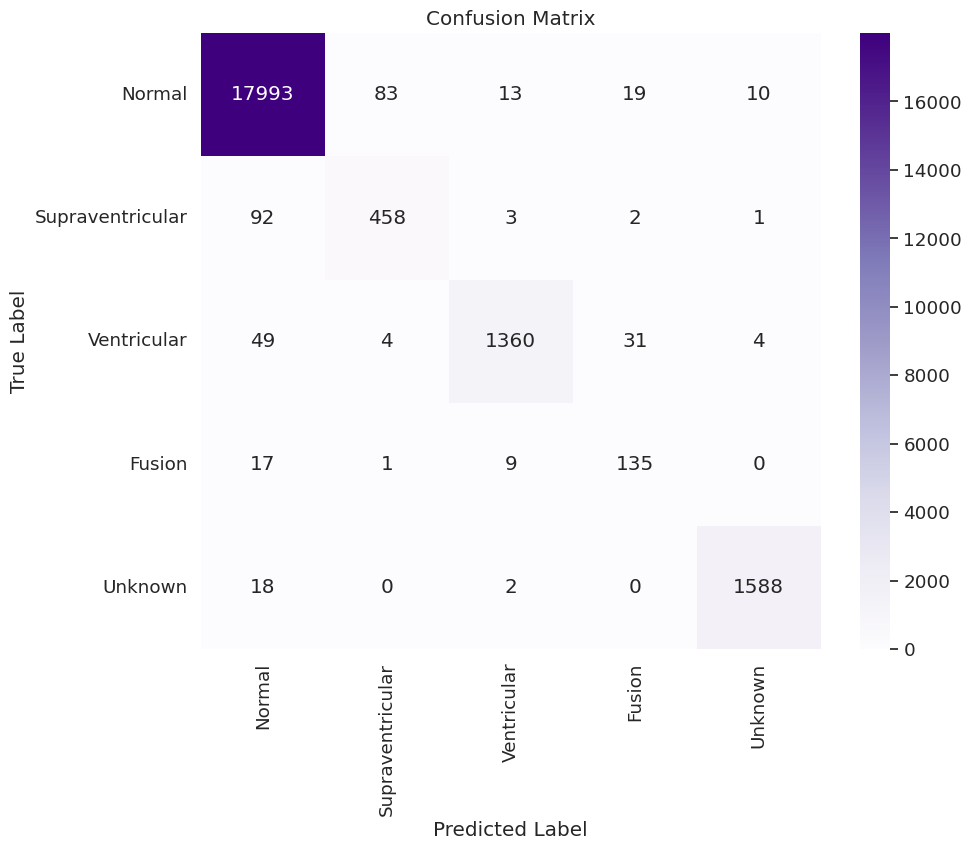

In [9]:
trained_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = trained_model(X_batch)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.numpy())

acc = accuracy_score(all_labels, all_preds)
label_names = ['Normal', 'Supraventricular', 'Ventricular', 'Fusion', 'Unknown']

print(f"Final Test Accuracy: {acc*100:.2f}%")
print(classification_report(all_labels, all_preds, target_names=label_names))

plt.figure(figsize=(10, 8))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()